> # Бајесова анализа на финансиски податоци од берзата на САД
> #### Јован Крајевски (199015)
> ##### јуни, 2022

## Собирање на податоци од берзата на САД

In [1]:
import yfinance
import time
import pandas as pd
from pathlib import Path

indexes = ["^GSPC"]

OVERWRITE_ANYWAY = False

DATA_LOCATION = Path(".") / "data"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)

start_time = time.time()

if OVERWRITE_ANYWAY or not (DATA_LOCATION / "indexes.pkl").is_file():
    daily_smp = yfinance.download(" ".join(indexes),
                                  period="max",
                                  interval="1d")
    daily_smp.to_pickle(DATA_LOCATION / "indexes.pkl")

daily_smp = pd.read_pickle(DATA_LOCATION / "indexes.pkl")

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

0.00s


In [2]:
daily_smp

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...,...
2022-05-23,3919.419922,3981.879883,3909.040039,3973.750000,3973.750000,3392770000
2022-05-24,3942.939941,3955.679932,3875.129883,3941.479980,3941.479980,3901640000
2022-05-25,3929.590088,3999.330078,3925.030029,3978.729980,3978.729980,4322190000


<IPython.core.display.Javascript object>


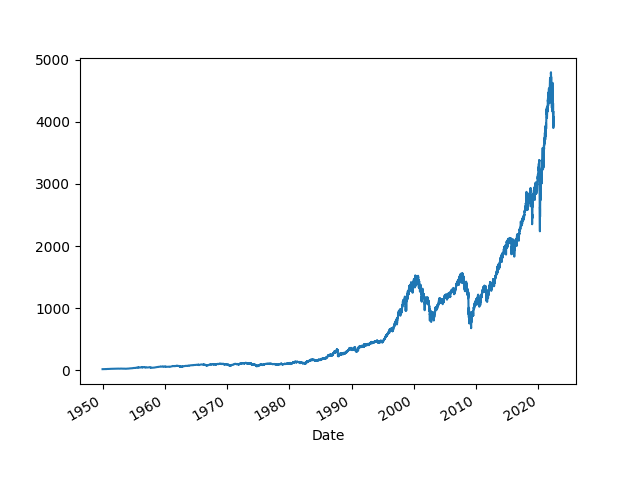

<AxesSubplot:xlabel='Date'>

In [3]:
%matplotlib notebook
daily_smp["Adj Close"].plot()

# Поделба на податоците на тренирачко и тестирачко множество

In [4]:
train_smp = daily_smp[daily_smp.index < "01-01-2007"].copy()
test_smp = daily_smp[daily_smp.index >= "01-01-2007"].copy()
len(train_smp), len(test_smp)

(14341, 3879)

# Трансформации на податоците

In [5]:
import numpy as np


def transform_close(df):
    df["close"] = df["Adj Close"]
    df["close_return"] = df["close"].pct_change(periods=1)
    df["close_diff"] = df["close"].diff(periods=1)
    df["close_log_return"] = np.log(df["close"]) - np.log(df["close"].shift(1))
    df.dropna(inplace=True)


transform_close(train_smp)
transform_close(test_smp)

<IPython.core.display.Javascript object>


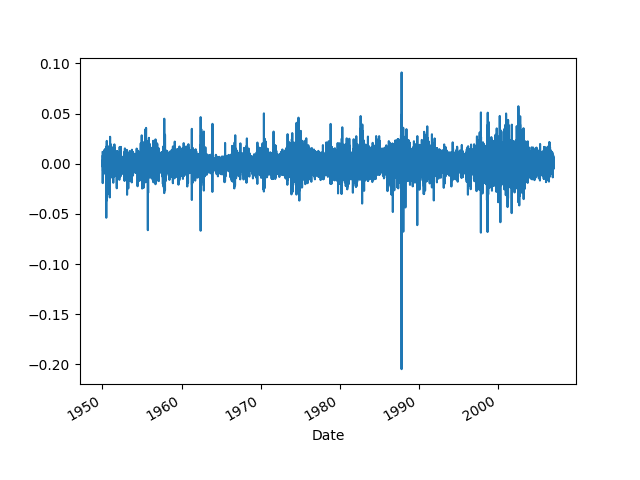

<AxesSubplot:xlabel='Date'>

In [6]:
train_smp["close_return"].plot()

<IPython.core.display.Javascript object>


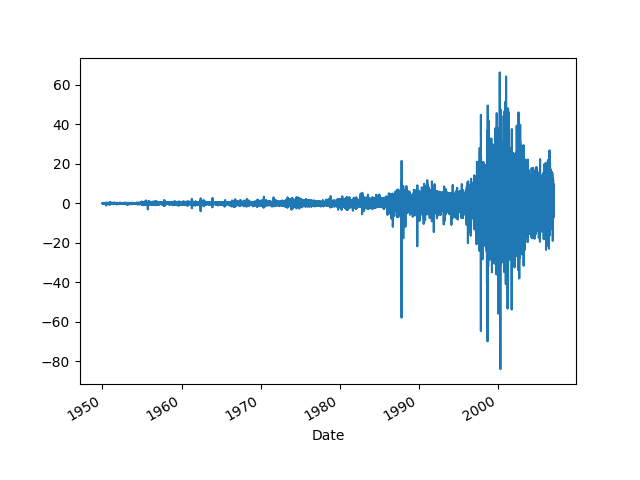

<AxesSubplot:xlabel='Date'>

In [7]:
train_smp["close_diff"].plot()

<IPython.core.display.Javascript object>


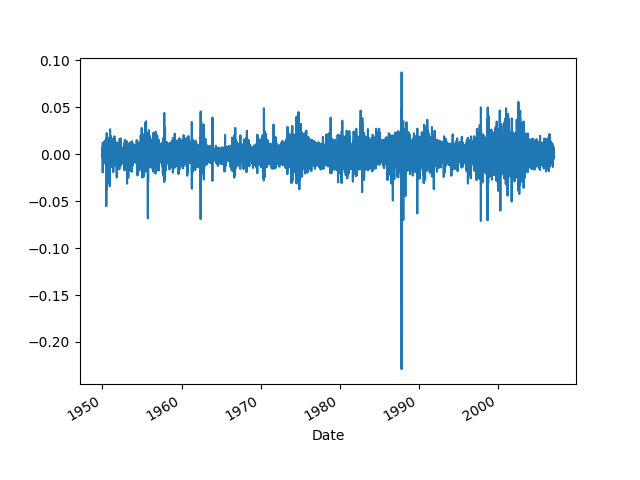

<AxesSubplot:xlabel='Date'>

In [8]:
train_smp["close_log_return"].plot()

# Стационарност

adf:  If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.
RESULT: stationary

kpss: If Test statistic < Critical Value and p-value < 0.05 – Fail to Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is trend stationary.
RESULT: not stationary

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss


def adf_test(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = {
        title: adf_test[idx]
        for idx, title in enumerate(
            ['Test Statistic', 'p-value', '#Lags Used'])
    }
    for key, value in adf_test[4].items():
        adf_output[f'Critical Value ({key})'] = value

    return adf_output


def kpss_test(timeseries):
    kpss_test = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = {
        title: kpss_test[idx]
        for idx, title in enumerate(
            ['Test Statistic', 'p-value', '#Lags Used'])
    }
    for key, value in kpss_test[3].items():
        kpss_output[f'Critical Value ({key})'] = value

    return kpss_output


def interpret_results(adf_output, kpss_output):
    reject_h0 = []
    for test_output in [adf_output, kpss_output]:
        is_test_stat_larger = True
        for key, value in test_output.items():
            if "Critical" not in key:
                continue

            is_test_stat_larger = is_test_stat_larger and (
                test_output["Test Statistic"] > value)

        reject_h0.append(not is_test_stat_larger
                         and test_output["p-value"] < 0.05)

    if reject_h0[0] and not reject_h0[1]:
        print("stationary")
    elif not reject_h0[0] and reject_h0[1]:
        print("non-stationary")
    elif not reject_h0[0] and not reject_h0[1]:
        print("trend-stationary")
    else:
        print("diff-stationary")


for series in ["close", "close_return", "close_diff", "close_log_return"]:
    adf_output = adf_test(train_smp[series])
    kpss_output = kpss_test(train_smp[series])
    print(series)
    interpret_results(adf_output, kpss_output)

/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


close
trend-stationary


/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


close_return
stationary
close_diff
diff-stationary
close_log_return
stationary


/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Авто-корелираност

The Durbin Watson test has values between 0 and 4. Below is the table containing values and their interpretations:

- 2: No autocorrelation. Generally, we assume 1.5 to 2.5 as no correlation.
- [0, 2): positive autocorrelation. The more close it to 0, the more signs of positive autocorrelation.
- (2 -4]: negative autocorrelation. The more close it to 4, the more signs of negative autocorrelation.

In [10]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS

for series in ["close_return", "close_log_return"]:
    X = np.arange(len(train_smp[series]))
    Y = np.asarray(train_smp[series])
    X = sm.add_constant(X)

    # Fit the ordinary least square method.
    ols_res = OLS(Y, X).fit()
    # apply durbin watson statistic on the ols residual
    dw = durbin_watson(ols_res.resid)
    print(f"{series} durbin-watson test value: {dw}")

close_return durbin-watson test value: 1.844345013591561
close_log_return durbin-watson test value: 1.8448787792469894


# Распределба на log-return

<IPython.core.display.Javascript object>


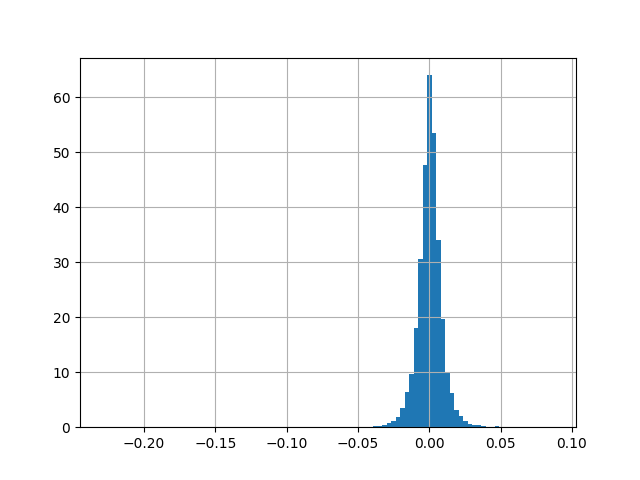

<AxesSubplot:>

In [11]:
train_smp["close_log_return"].hist(bins=100, density=True)

In [12]:
from scipy import stats


def get_distribution(df):
    cauchy_p_value = stats.kstest(df, "cauchy", stats.cauchy.fit(df))[1]
    gennorm_p_value = stats.kstest(df, "gennorm", stats.gennorm.fit(df))[1]
    p_values = list(zip([cauchy_p_value, gennorm_p_value], [0, 1]))

    return max(p_values)[1]

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


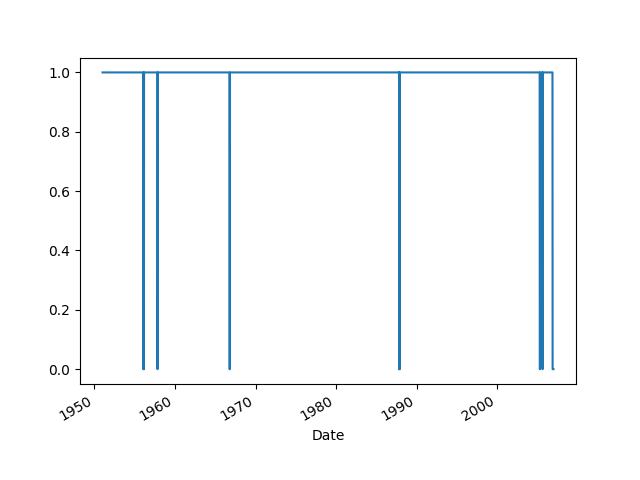

35.66s


In [13]:
from pandarallel import pandarallel

pandarallel.initialize()

start_time = time.time()
x = train_smp["close_log_return"].interpolate()
dists = x.rolling(250).parallel_apply(get_distribution)
dists.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

In [14]:
(dists == 1).mean(), (dists == 0).mean()

(0.9755230125523012, 0.007112970711297071)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


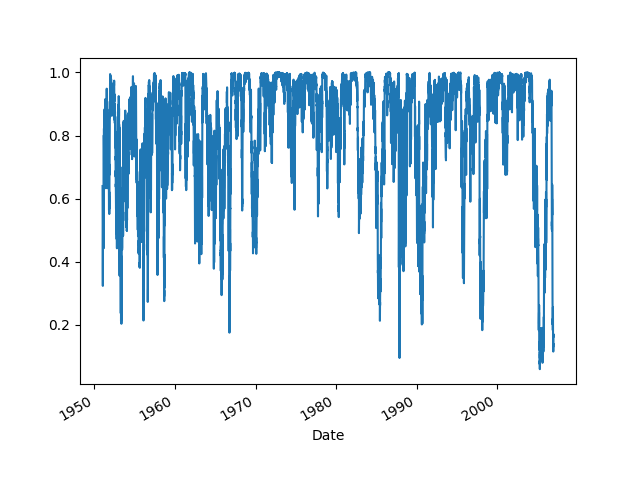

28.57s


In [15]:
def get_gennorm_p_values(df):
    return stats.kstest(df, "gennorm", stats.gennorm.fit(df))[1]


pandarallel.initialize()
start_time = time.time()
x = train_smp["close_log_return"].interpolate()
gennorm_p_values = x.rolling(250).parallel_apply(get_gennorm_p_values)
gennorm_p_values.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

In [16]:
gennorm_p_values.mean()

0.8211481553531417

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


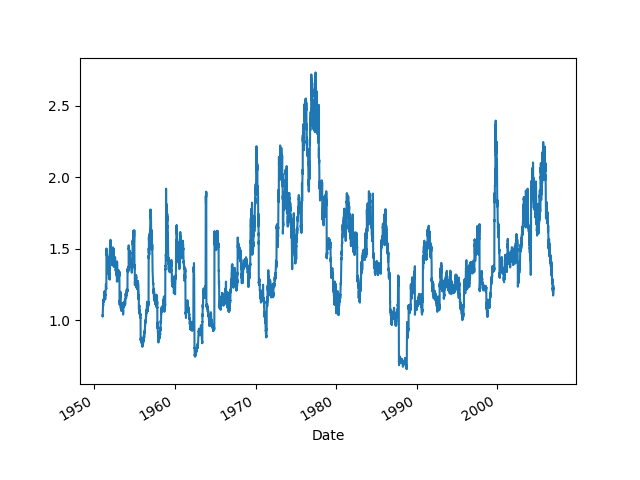

26.95s


In [17]:
from pandarallel import pandarallel


def get_gennorm_betas(df):
    return stats.gennorm.fit(df)[0]


pandarallel.initialize()
start_time = time.time()
x = train_smp["close_log_return"].interpolate()
betas = x.rolling(250).parallel_apply(get_gennorm_betas)
betas.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

In [18]:
prior_beta_mean, prior_beta_sigma = betas.mean(), betas.std()
prior_beta_mean, prior_beta_sigma

(1.4023509111239734, 0.34852008255186584)

<IPython.core.display.Javascript object>


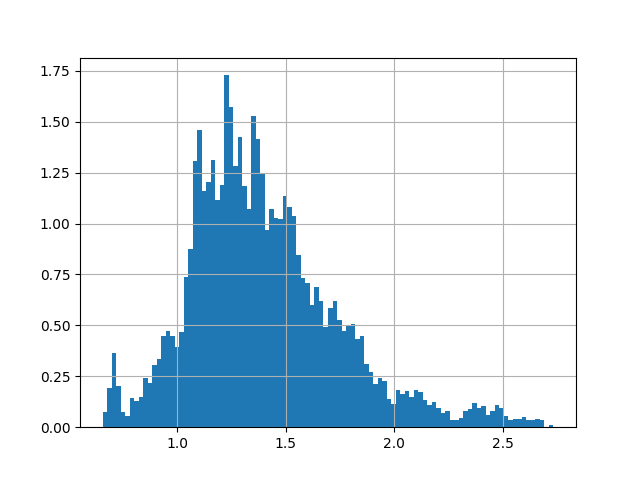

<AxesSubplot:>

In [19]:
betas.hist(density=True, bins=100)

# Прозорци (rolling windows)

In [20]:
def get_rolling_windows(df, L=250):
    return [df.iloc[x:x + L] for x in range(len(df) - L + 1)]


start_time = time.time()

train_data = get_rolling_windows(train_smp)
test_data = get_rolling_windows(test_smp)

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

len(train_data), len(test_data)

0.53s


(14091, 3629)

In [21]:
train_data[0]

,Open,High,Low,Close,Adj Close,Volume,close,close_return,close_diff,close_log_return
Date,,,,,,,,,,
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000,16.850000,0.011405,0.190001,0.011340
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000,16.930000,0.004748,0.080000,0.004737
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000,16.980000,0.002953,0.049999,0.002949
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000,17.080000,0.005889,0.100000,0.005872
1950-01-10,17.030001,17.030001,17.030001,17.030001,17.030001,2160000,17.030001,-0.002927,-0.049999,-0.002932
...,...,...,...,...,...,...,...,...,...,...
1950-12-27,20.299999,20.299999,20.299999,20.299999,20.299999,2940000,20.299999,0.019076,0.379999,0.018897
1950-12-28,20.379999,20.379999,20.379999,20.379999,20.379999,3560000,20.379999,0.003941,0.080000,0.003933
1950-12-29,20.430000,20.430000,20.430000,20.430000,20.430000,3440000,20.430000,0.002453,0.050001,0.002450


# Бајесова анализа

In [22]:
import numpy as np
import pymc as pm
from scipy import stats as ss


def from_posterior(param, samples, testval, set_testval):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = ss.gaussian_kde(samples.data.flatten())(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    if set_testval:
        return pm.distributions.Interpolated(param, x, y, initval=testval)

    return pm.distributions.Interpolated(param, x, y, initval=testval)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [23]:
def get_stats(sample):
    return [
        np.mean(sample),
        ss.tstd(sample),
        np.mean(sample > 0),
        ss.skew(sample),
        ss.kurtosis(sample),
    ] + [np.percentile(sample, p) for p in range(0, 101, 5)]


get_stats(np.random.randn(10000))

[0.012809654361287287,
 0.9990920838535808,
 0.5034,
 -0.0077028474201400665,
 0.01591946882749884,
 -3.8864745142904424,
 -1.6170776541990697,
 -1.2570218066553074,
 -1.0011766411733538,
 -0.8222855325292371,
 -0.6543244955042347,
 -0.5100872858262262,
 -0.3710124254732676,
 -0.24536337052905574,
 -0.11509911006071315,
 0.008820040630429887,
 0.13534176512473658,
 0.2644137591244615,
 0.39360184981129304,
 0.5304133181319476,
 0.6923459550411031,
 0.8555366918907807,
 1.052536056434796,
 1.2946252685095816,
 1.6562020035372598,
 3.7534083085892065]

## Бајесова анализа со нормален приор

In [24]:
import cloudpickle
import pickle

DATA_LOCATION = Path(".") / "models"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)


def read_stats_and_model(model_name):
    if not (DATA_LOCATION / model_name).is_file():
        return [], None

    with open(DATA_LOCATION / model_name, "rb") as f:
        return pickle.load(f)


def write_stats_and_model(model_name, stats, model):
    with open(DATA_LOCATION / model_name, "wb") as f:
        cloudpickle.dump((stats, model), f)

In [25]:
def get_initial_normal_model(data, prior_mu_mean, prior_mu_sigma,
                             prior_std_sigma):
    mu_testval, std_testval = ss.norm.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = pm.Normal("mu",
                       mu=prior_mu_mean,
                       sigma=prior_mu_sigma,
                       initval=mu_testval)
        std = pm.HalfNormal("std", sigma=prior_std_sigma, initval=std_testval)
        obs = pm.Normal("obs", mu=mu, sigma=std, observed=data)

    return model


def get_next_normal_model(data, trace, set_testval):
    mu_testval, std_testval = ss.norm.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = from_posterior("mu", trace["posterior"]["mu"], mu_testval,
                            set_testval)
        std = from_posterior("std", trace["posterior"]["std"], std_testval,
                             set_testval)
        obs = pm.Normal("obs", mu=mu, sigma=std, observed=data)

    return model

In [26]:
start_time = time.time()

prior_mu_mean = np.array(
    [window["close_log_return"].mean() for window in train_data]).mean()
prior_mu_sigma = np.array(
    [window["close_log_return"].mean() for window in train_data]).std(ddof=1)
prior_std_sigma = np.array(
    [window["close_log_return"].std() for window in train_data]).std(ddof=1)

end_time = time.time()
print(f"{end_time - start_time:.2f}s")
print(prior_mu_mean, prior_mu_sigma, prior_std_sigma)

2.54s
0.000302779667213874 0.0005921371039989852 0.003211753846880127


In [27]:
import aesara

data_sample = aesara.shared(train_data[0]["close_log_return"].to_numpy())

model = get_initial_normal_model(data_sample, prior_mu_mean, prior_mu_sigma,
                                 prior_std_sigma)

with model:
    trace = pm.sample(draws=1000, step=[pm.Metropolis()], chains=4, cores=4)
    posterior_obs = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<IPython.core.display.Javascript object>


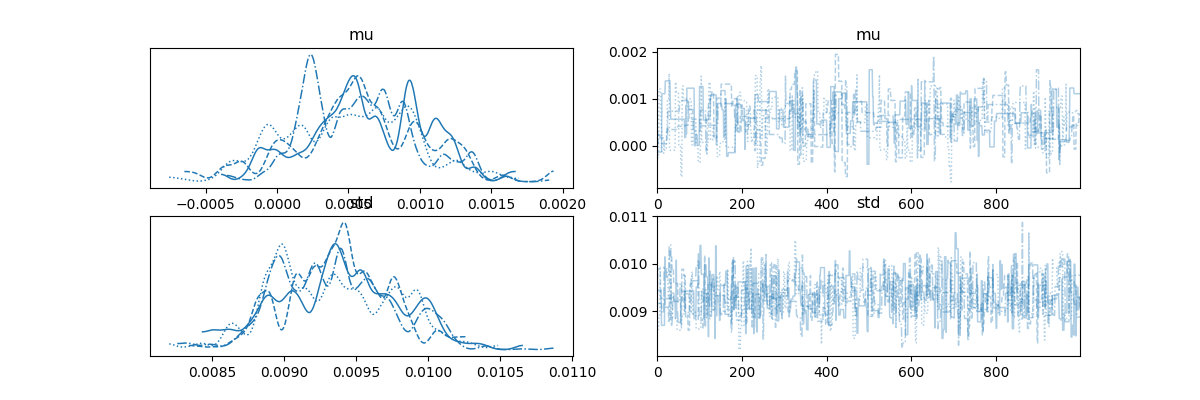

<IPython.core.display.Javascript object>


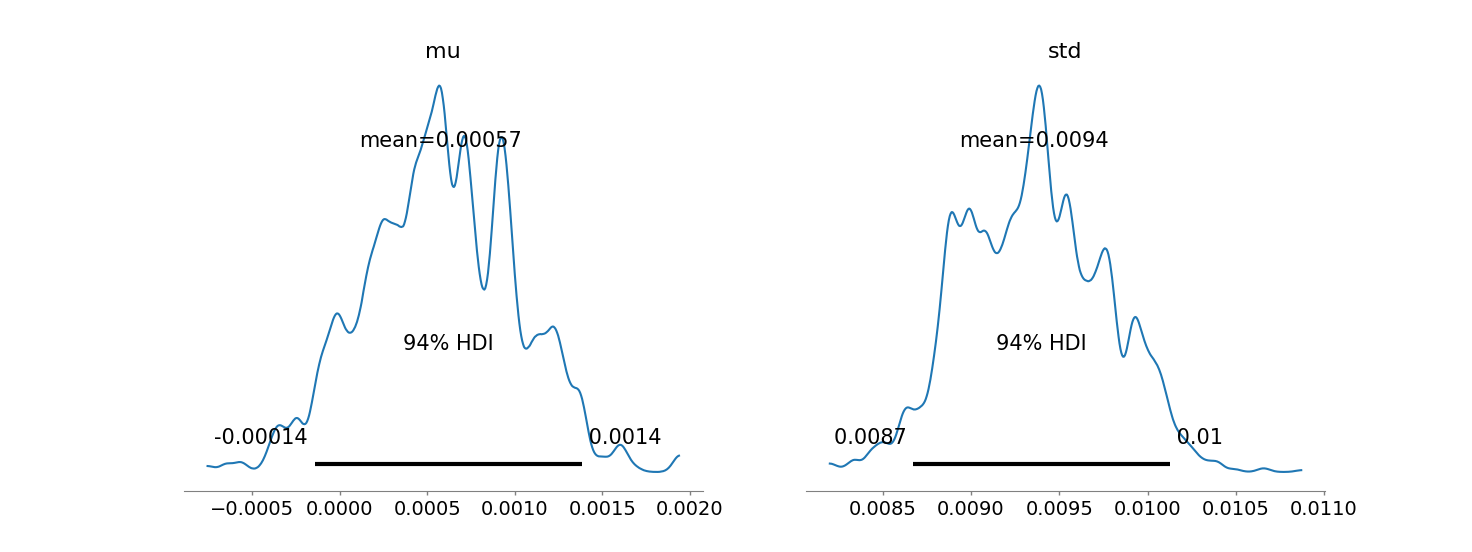

In [28]:
import arviz as az
with model:
    az.plot_trace(trace)
    az.plot_posterior(trace)

<IPython.core.display.Javascript object>


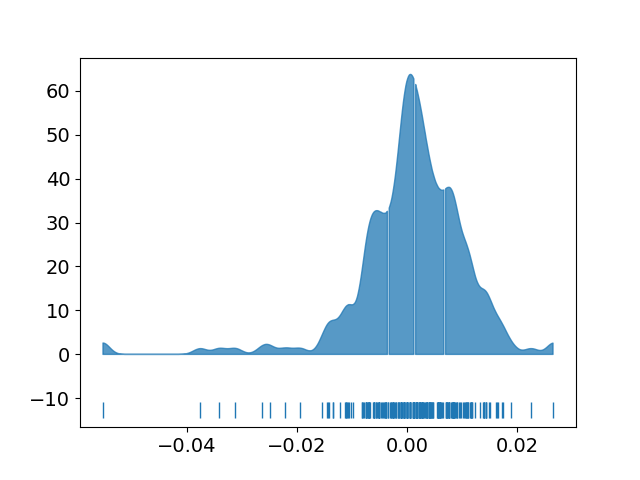

In [29]:
with model:
    az.plot_dist(posterior_obs["observed_data"]["obs"],
                 rug=True,
                 quantiles=[.25, .5, .75])

In [30]:
data_sample = aesara.shared(train_data[1]["close_log_return"].to_numpy())

model = get_next_normal_model(data_sample, trace, True)

with model:
    trace = pm.sample(draws=1000, step=[pm.Metropolis()], chains=4, cores=4)
    posterior_obs = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<IPython.core.display.Javascript object>


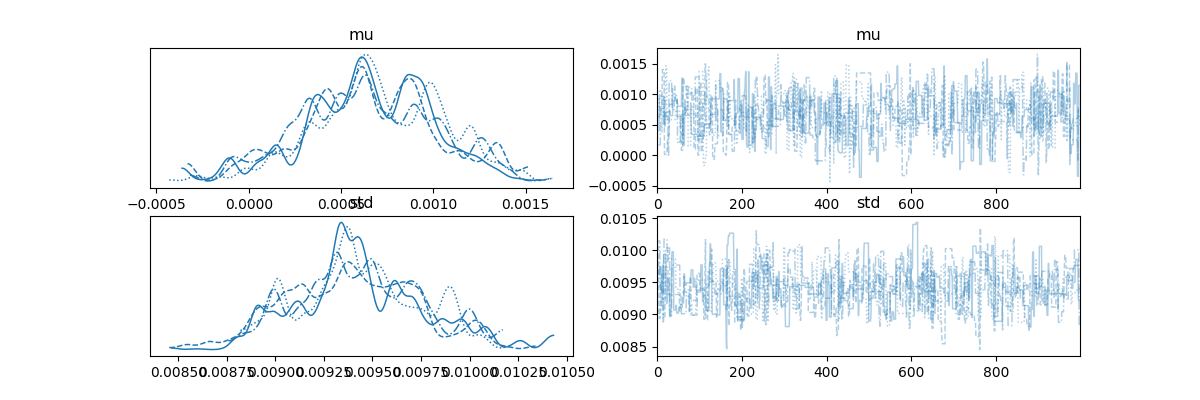

<IPython.core.display.Javascript object>


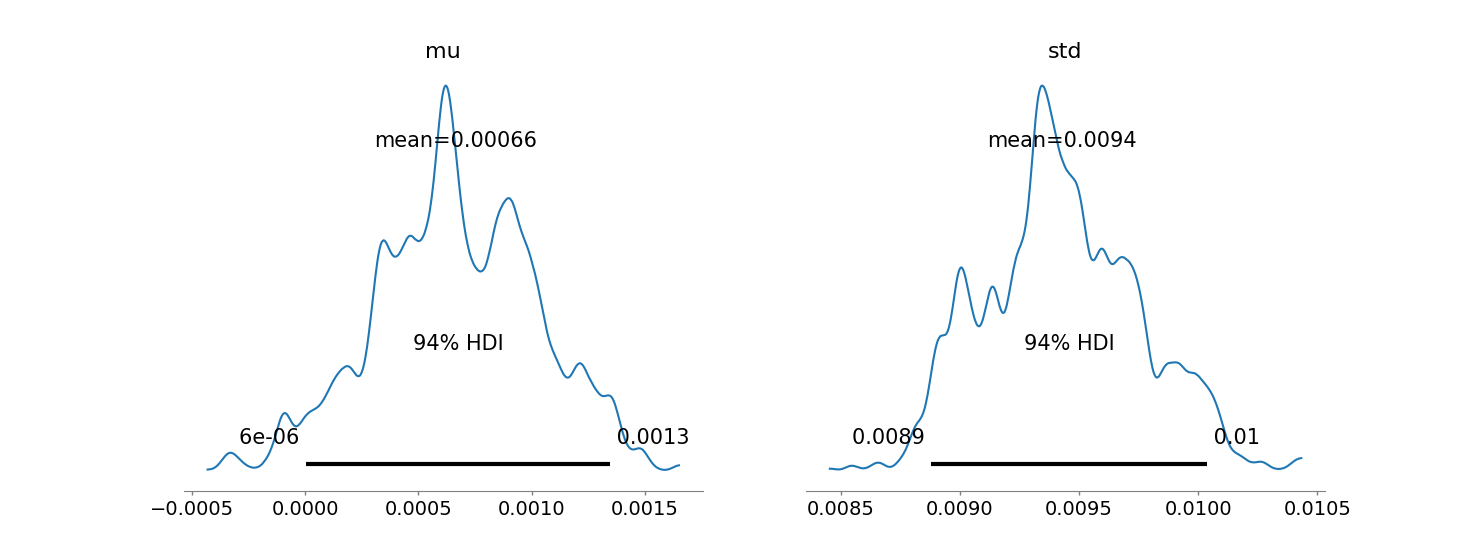

In [31]:
with model:
    az.plot_trace(trace)
    az.plot_posterior(trace)

<IPython.core.display.Javascript object>


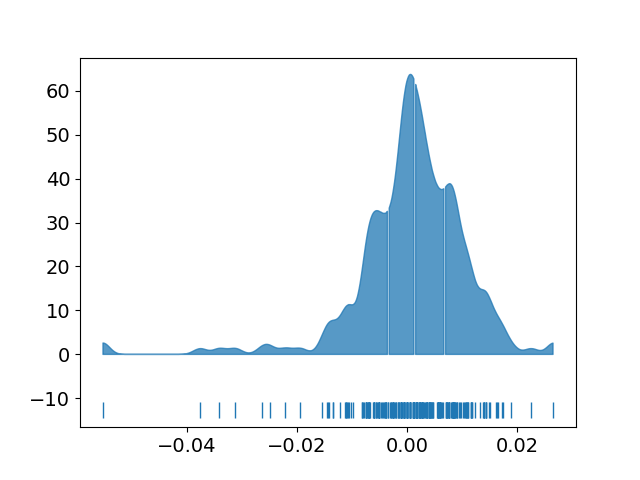

In [32]:
with model:
    az.plot_dist(posterior_obs["observed_data"]["obs"],
                 rug=True,
                 quantiles=[.25, .5, .75])

In [33]:
import aesara


def train_model(
        model_name,
        get_initial_model_func,
        initial_model_args,
        get_next_model_func,
        update_priors_on=60,  # update priors after 60 windows
        save_every=10,  # save model after 10 windows
        verbosity=10,  # print info about progress after 10 windows
        draws=1000,
        chains=4,
        cores=4):
    success = False
    while not success:
        try:
            data_sample = aesara.shared(
                train_data[0]["close_log_return"].to_numpy())

            stats, model = read_stats_and_model(model_name)
            trace = None

            if not model:
                model = get_initial_model_func(data_sample,
                                               *initial_model_args)

            if len(stats) and len(stats) % update_priors_on == 0:
                # recalculate last window so that we have trace
                stats = stats[:-1]

            for idx, window in enumerate(train_data):
                if idx % verbosity == 0:
                    print(
                        f"Window {idx + 1}/{len(train_data)} ({(idx + 1)/len(train_data)*100:.2f}%)..."
                    )

                if idx < len(stats):
                    continue  # window is already processed

                data_sample.set_value(window["close_log_return"].to_numpy())

                if idx % update_priors_on == 0 and idx > 0:
                    next_model = get_next_model_func(data_sample, trace, True)
                    if not np.isnan(
                            np.array(list(
                                next_model.point_logps().values()))).any():
                        model = next_model
                    else:
                        with open("logs.txt", "a") as f:
                            f.write(
                                f"{model_name}_{idx} - Failed set_testval\n")

                        model = get_next_model_func(data_sample, trace, False)

                with model:
                    trace = pm.sample(draws=draws,
                                      step=[pm.Metropolis()],
                                      chains=chains,
                                      cores=cores,
                                      progressbar=False)
                    posterior_obs = pm.sample_posterior_predictive(
                        trace, progressbar=False)

                stats.append(
                    get_stats(
                        posterior_obs["observed_data"]["obs"].data.flatten()))

                if idx % save_every == 0:
                    write_stats_and_model(model_name, stats, model)

            write_stats_and_model(model_name, stats, model)
            success = True
        except Exception as e:
            with open("logs.txt", "a") as f:
                f.write(str(e))
                f.write("\n")

# Бајесова анализа со двојно-експоненцијален (Лапласов) приор

In [34]:
def get_initial_laplace_model(data, prior_mu_mean, prior_mu_sigma,
                              prior_std_sigma):
    mu_testval, b_testval = ss.laplace.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = pm.Normal("mu",
                       mu=prior_mu_mean,
                       sigma=prior_mu_sigma,
                       initval=mu_testval)
        b = pm.HalfNormal("b", sigma=prior_std_sigma, initval=b_testval)
        obs = pm.Laplace("obs", mu=mu, b=b, observed=data)

    return model


def get_next_laplace_model(data, trace, set_testval):
    mu_testval, b_testval = ss.laplace.fit(data.get_value())
    model = pm.Model()
    with model:
        mu = from_posterior("mu", trace["posterior"]["mu"], mu_testval,
                            set_testval)
        b = from_posterior("b", trace["posterior"]["b"], b_testval,
                           set_testval)
        obs = pm.Laplace("obs", mu=mu, b=b, observed=data)

    return model

In [35]:
train_model("fixed_normal_metropolis.pkl", get_initial_normal_model,
            [prior_mu_mean, prior_mu_sigma, prior_std_sigma],
            get_next_normal_model)
train_model("fixed_laplace_metropolis.pkl", get_initial_laplace_model,
            [prior_mu_mean, prior_mu_sigma, prior_std_sigma],
            get_next_laplace_model)

Window 1/14091 (0.01%)...
Window 11/14091 (0.08%)...
Window 21/14091 (0.15%)...
Window 31/14091 (0.22%)...
Window 41/14091 (0.29%)...
Window 51/14091 (0.36%)...
Window 61/14091 (0.43%)...
Window 71/14091 (0.50%)...
Window 81/14091 (0.57%)...
Window 91/14091 (0.65%)...
Window 101/14091 (0.72%)...
Window 111/14091 (0.79%)...
Window 121/14091 (0.86%)...
Window 131/14091 (0.93%)...
Window 141/14091 (1.00%)...
Window 151/14091 (1.07%)...
Window 161/14091 (1.14%)...
Window 171/14091 (1.21%)...
Window 181/14091 (1.28%)...
Window 191/14091 (1.36%)...
Window 201/14091 (1.43%)...
Window 211/14091 (1.50%)...
Window 221/14091 (1.57%)...
Window 231/14091 (1.64%)...
Window 241/14091 (1.71%)...
Window 251/14091 (1.78%)...
Window 261/14091 (1.85%)...
Window 271/14091 (1.92%)...
Window 281/14091 (1.99%)...
Window 291/14091 (2.07%)...
Window 301/14091 (2.14%)...
Window 311/14091 (2.21%)...
Window 321/14091 (2.28%)...
Window 331/14091 (2.35%)...
Window 341/14091 (2.42%)...
Window 351/14091 (2.49%)...
Win

Window 1/14091 (0.01%)...
Window 11/14091 (0.08%)...
Window 21/14091 (0.15%)...
Window 31/14091 (0.22%)...
Window 41/14091 (0.29%)...
Window 51/14091 (0.36%)...
Window 61/14091 (0.43%)...
Window 71/14091 (0.50%)...
Window 81/14091 (0.57%)...
Window 91/14091 (0.65%)...
Window 101/14091 (0.72%)...
Window 111/14091 (0.79%)...
Window 121/14091 (0.86%)...
Window 131/14091 (0.93%)...
Window 141/14091 (1.00%)...
Window 151/14091 (1.07%)...
Window 161/14091 (1.14%)...
Window 171/14091 (1.21%)...
Window 181/14091 (1.28%)...
Window 191/14091 (1.36%)...
Window 201/14091 (1.43%)...
Window 211/14091 (1.50%)...
Window 221/14091 (1.57%)...
Window 231/14091 (1.64%)...
Window 241/14091 (1.71%)...
Window 251/14091 (1.78%)...
Window 261/14091 (1.85%)...
Window 271/14091 (1.92%)...
Window 281/14091 (1.99%)...
Window 291/14091 (2.07%)...
Window 301/14091 (2.14%)...
Window 311/14091 (2.21%)...
Window 321/14091 (2.28%)...
Window 331/14091 (2.35%)...
Window 341/14091 (2.42%)...
Window 351/14091 (2.49%)...
Win

# Бајесова анализа со обопштена нормална дистрибуција

In [36]:
import numpy as np
from aesara.tensor.var import TensorVariable
from aesara.tensor.random.op import RandomVariable
from typing import List, Tuple


class GenNormRV(RandomVariable):
    name: str = "GenNorm"
    ndim_supp: int = 0
    ndims_params: List[int] = [0, 0, 0]
    dtype: str = "floatX"
    _print_name: Tuple[str, str] = ("GenNorm", "GGD")

    @classmethod
    def rng_fn(
        cls,
        rng: np.random.RandomState,
        beta: np.ndarray,
        loc: np.ndarray,
        scale: np.ndarray,
        size: Tuple[int, ...],
    ) -> np.ndarray:
        return ss.gennorm.rvs(beta, loc, scale, random_state=rng, size=size)

In [37]:
import aesara.tensor as at
from pymc.aesaraf import floatX, intX
from pymc.distributions.distribution import Continuous
from pymc.distributions.dist_math import check_parameters

class GenNorm(Continuous):
    rv_op = GenNormRV()

    @classmethod
    def dist(cls, beta, loc, scale, *args, **kwargs):
        beta = at.as_tensor_variable(floatX(beta))
        loc = at.as_tensor_variable(floatX(loc))
        scale = at.as_tensor_variable(floatX(scale))
        return super().dist([beta, loc, scale], *args, **kwargs)

    def moment(rv, size, beta, loc, scale):
        moment, _ = at.broadcast_arrays(beta, loc, scale)
        if not rv_size_is_none(size):
            moment = at.full(size, moment)
        return moment

    def logp(value, beta, loc, scale):
        return check_parameters(
            at.log(beta / (2 * scale)) - at.gammaln(1.0 / beta) -
            (at.abs_(value - loc) / scale)**beta, beta >= 0, scale >= 0)

    def logcdf(value, beta, loc, scale):
        b = value - loc
        c = 0.5 * b / at.abs_(b)
        return (0.5 + c) - c * at.gammaincc(1.0 / beta,
                                            at.abs_(b / scale)**beta)

In [38]:
def get_initial_gennorm_model(data, prior_mu_mean, prior_mu_sigma,
                              prior_beta_mean, prior_beta_sigma,
                              prior_std_sigma):
    beta_testval, loc_testval, scale_testval = ss.gennorm.fit(data.get_value())
    model = pm.Model()
    with model:
        beta = pm.TruncatedNormal("beta",
                                  mu=prior_beta_mean,
                                  sigma=prior_beta_sigma,
                                  lower=0,
                                  initval=beta_testval)
        loc = pm.Normal("loc",
                        mu=prior_mu_mean,
                        sigma=prior_mu_sigma,
                        initval=loc_testval)
        scale = pm.HalfNormal("scale",
                              sigma=prior_std_sigma,
                              initval=scale_testval)
        obs = GenNorm("obs", beta=beta, loc=loc, scale=scale, observed=data)

    return model


def get_next_gennorm_model(data, trace, set_testval):
    beta_testval, loc_testval, scale_testval = ss.gennorm.fit(data.get_value())
    model = pm.Model()
    with model:
        beta = from_posterior("beta", trace["posterior"]["beta"], beta_testval,
                              set_testval)
        loc = from_posterior("loc", trace["posterior"]["loc"], loc_testval,
                             set_testval)
        scale = from_posterior("scale", trace["posterior"]["scale"],
                               scale_testval, set_testval)
        obs = GenNorm("obs", beta=beta, loc=loc, scale=scale, observed=data)

    return model

In [39]:
import aesara

data_sample = aesara.shared(train_data[0]["close_log_return"].to_numpy())

model = get_initial_gennorm_model(data_sample, prior_mu_mean, prior_mu_sigma,
                                  prior_beta_mean, prior_beta_sigma,
                                  prior_std_sigma)

with model:
    trace = pm.sample(draws=1000, step=[pm.Metropolis()], chains=4, cores=4)
    posterior_obs = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [loc]
>Metropolis: [scale]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<IPython.core.display.Javascript object>


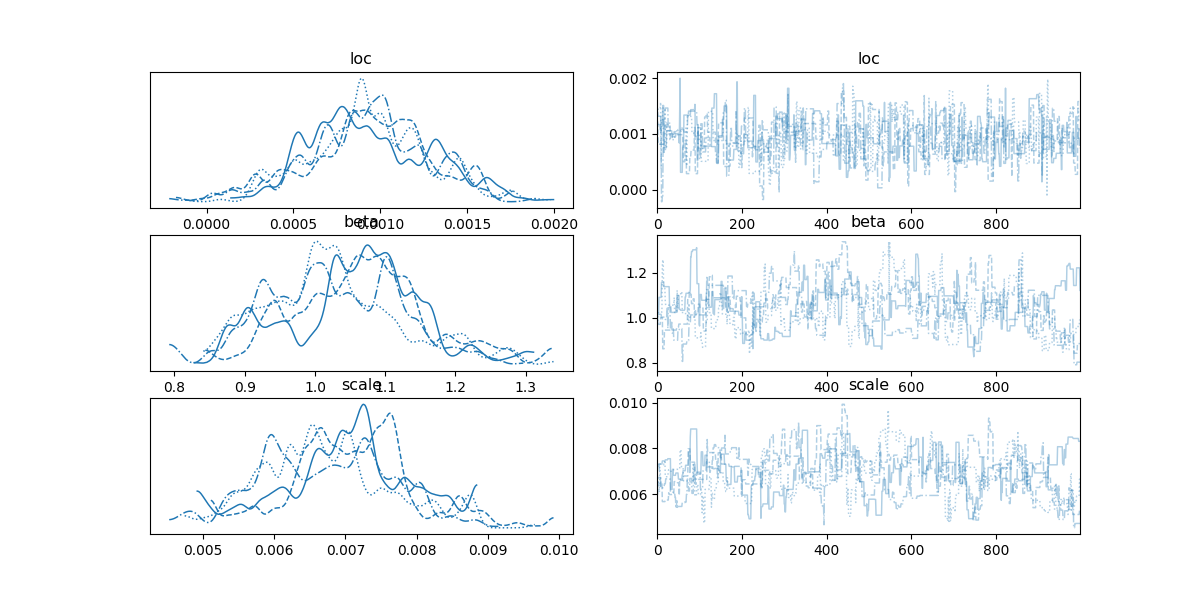

<IPython.core.display.Javascript object>


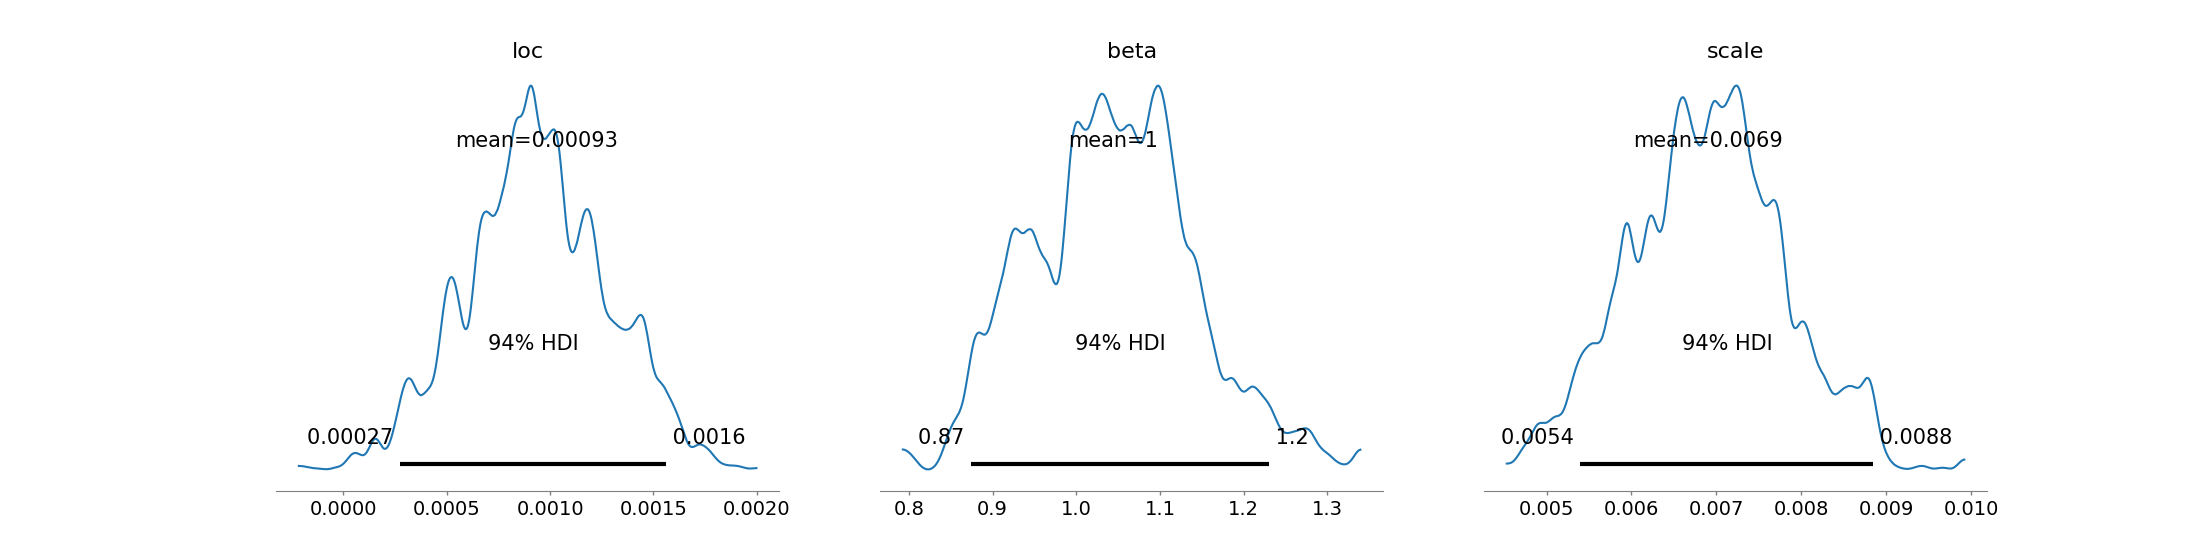

In [40]:
import arviz as az
with model:
    az.plot_trace(trace)
    az.plot_posterior(trace)

<IPython.core.display.Javascript object>


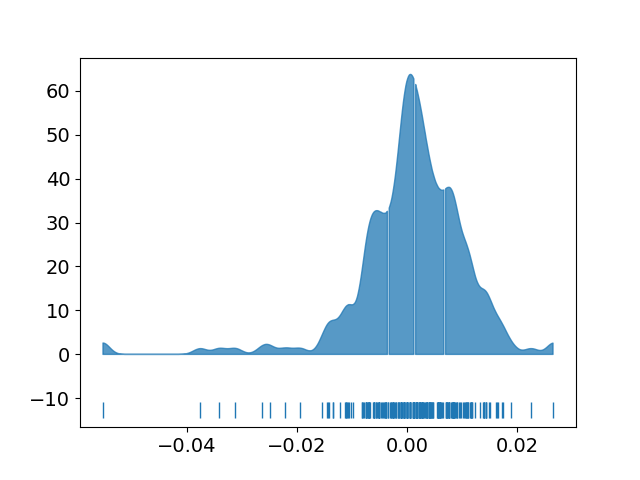

In [41]:
with model:
    az.plot_dist(posterior_obs["observed_data"]["obs"],
                 rug=True,
                 quantiles=[.25, .5, .75])

In [42]:
data_sample = aesara.shared(train_data[1]["close_log_return"].to_numpy())

model = get_next_gennorm_model(data_sample, trace, True)

with model:
    trace = pm.sample(draws=1000, step=[pm.Metropolis()], chains=4, cores=4)
    posterior_obs = pm.sample_posterior_predictive(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [loc]
>Metropolis: [scale]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


<IPython.core.display.Javascript object>


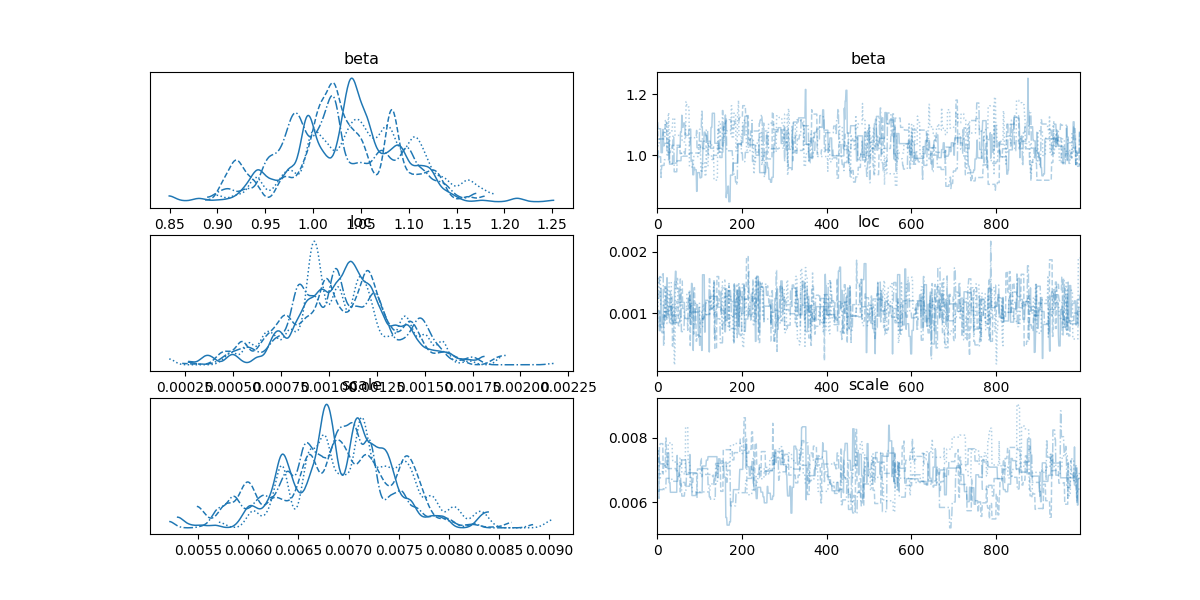

<IPython.core.display.Javascript object>


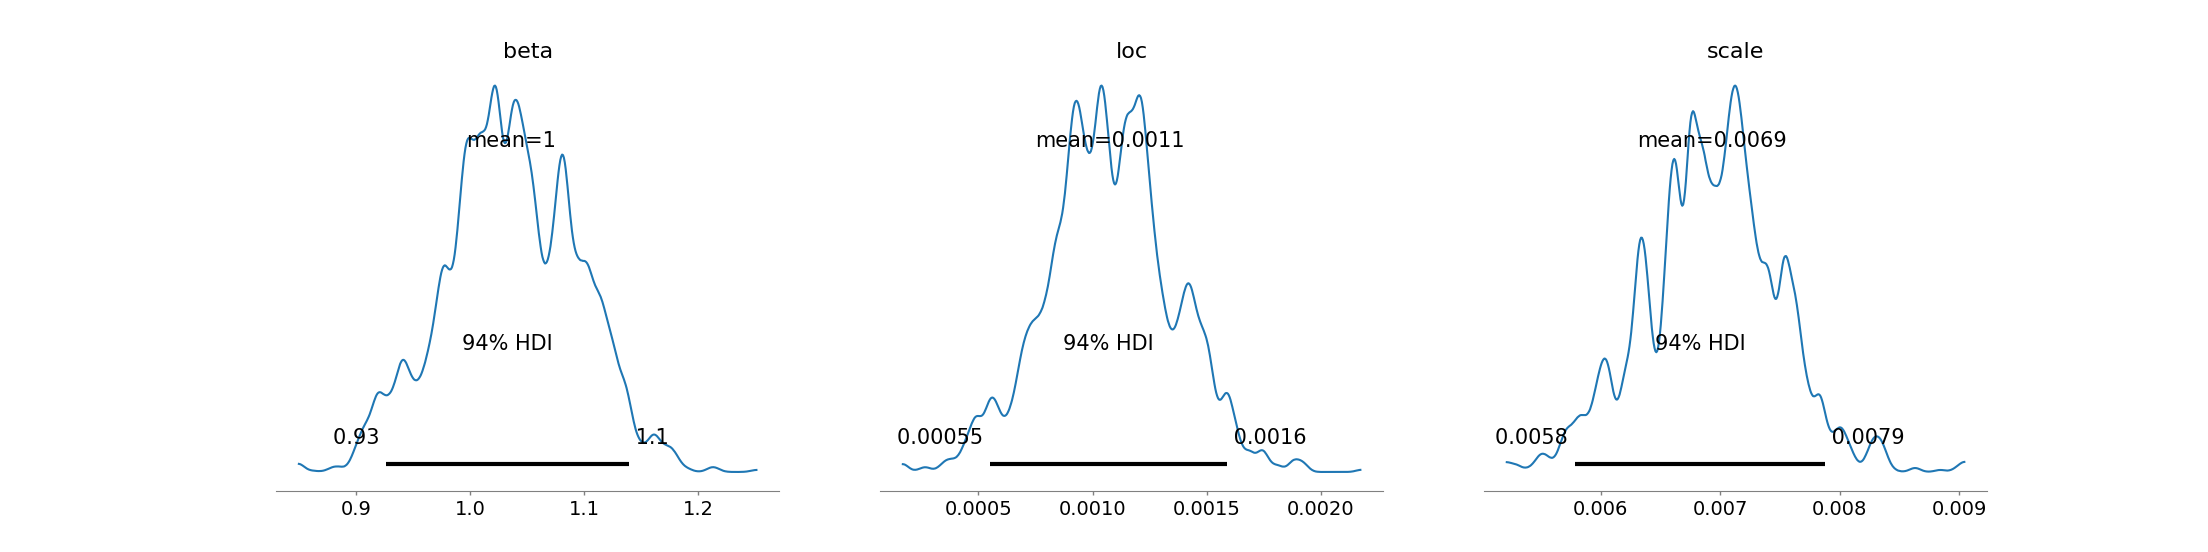

In [43]:
with model:
    az.plot_trace(trace)
    az.plot_posterior(trace)

<IPython.core.display.Javascript object>


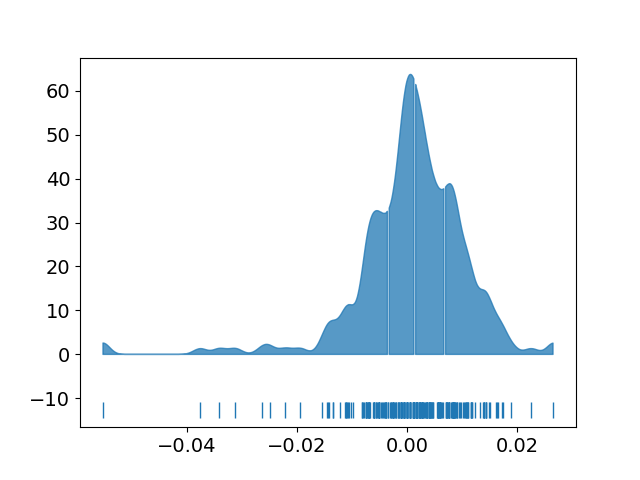

In [44]:
with model:
    az.plot_dist(posterior_obs["observed_data"]["obs"],
                 rug=True,
                 quantiles=[.25, .5, .75])

In [45]:
train_model("fixed_gennorm_metropolis.pkl", get_initial_gennorm_model, [
    prior_mu_mean, prior_mu_sigma, prior_beta_mean, prior_beta_sigma,
    prior_std_sigma
], get_next_gennorm_model)

Window 1/14091 (0.01%)...
Window 11/14091 (0.08%)...
Window 21/14091 (0.15%)...
Window 31/14091 (0.22%)...
Window 41/14091 (0.29%)...
Window 51/14091 (0.36%)...
Window 61/14091 (0.43%)...
Window 71/14091 (0.50%)...
Window 81/14091 (0.57%)...
Window 91/14091 (0.65%)...
Window 101/14091 (0.72%)...
Window 111/14091 (0.79%)...
Window 121/14091 (0.86%)...
Window 131/14091 (0.93%)...
Window 141/14091 (1.00%)...
Window 151/14091 (1.07%)...
Window 161/14091 (1.14%)...
Window 171/14091 (1.21%)...
Window 181/14091 (1.28%)...
Window 191/14091 (1.36%)...
Window 201/14091 (1.43%)...
Window 211/14091 (1.50%)...
Window 221/14091 (1.57%)...
Window 231/14091 (1.64%)...
Window 241/14091 (1.71%)...
Window 251/14091 (1.78%)...
Window 261/14091 (1.85%)...
Window 271/14091 (1.92%)...
Window 281/14091 (1.99%)...
Window 291/14091 (2.07%)...
Window 301/14091 (2.14%)...
Window 311/14091 (2.21%)...
Window 321/14091 (2.28%)...
Window 331/14091 (2.35%)...
Window 341/14091 (2.42%)...
Window 351/14091 (2.49%)...
Win

# Тестирање на моделите

In [46]:
def test_model(
        train_model_name,
        get_next_model_func,
        update_priors_on=60,  # update priors after 60 windows
        save_every=10,  # save model after 10 windows
        verbosity=10,  # print info about progress after 10 windows
        draws=1000,
        chains=4,
        cores=4):
    success = False
    while not success:
        try:
            [file_name, file_extenstion] = train_model_name.split('.')
            test_model_name = f"{file_name}_test.{file_extenstion}"
            data_sample = aesara.shared(
                test_data[0]["close_log_return"].to_numpy())

            train_stats, train_model = read_stats_and_model(train_model_name)
            test_stats, test_model = read_stats_and_model(test_model_name)
            trace = None

            if not test_model:
                test_model = train_model

            if len(test_stats) and len(test_stats) % update_priors_on == 0:
                # recalculate last window so that we have trace
                test_stats = test_stats[:-1]

            for idx, window in enumerate(test_data):
                if idx % verbosity == 0:
                    print(
                        f"Window {idx + 1}/{len(test_data)} ({(idx + 1)/len(test_data)*100:.2f}%)..."
                    )

                if idx < len(test_stats):
                    continue  # window is already processed

                data_sample.set_value(window["close_log_return"].to_numpy())

                if idx % update_priors_on == 0 and idx > 0:
                    next_model = get_next_model_func(data_sample, trace, True)
                    if not np.isnan(
                            np.array(list(
                                next_model.point_logps().values()))).any():
                        test_model = next_model
                    else:
                        with open("logs.txt", "a") as f:
                            f.write(
                                f"{test_model_name}_{idx} - Failed set_testval\n"
                            )

                        test_model = get_next_model_func(
                            data_sample, trace, False)

                with test_model:
                    trace = pm.sample(draws=draws,
                                      step=[pm.Metropolis()],
                                      chains=chains,
                                      cores=cores,
                                      progressbar=False)
                    posterior_obs = pm.sample_posterior_predictive(
                        trace, progressbar=False)

                test_stats.append(
                    get_stats(
                        posterior_obs["observed_data"]["obs"].data.flatten()))
                if idx % save_every == 0:
                    write_stats_and_model(test_model_name, test_stats,
                                          test_model)

            write_stats_and_model(test_model_name, test_stats, test_model)
            success = True
        except Exception as e:
            with open("logs.txt", "a") as f:
                f.write(str(e))
                f.write("\n")

In [47]:
test_model("fixed_normal_metropolis.pkl", get_next_normal_model)
test_model("fixed_laplace_metropolis.pkl", get_next_laplace_model)
test_model("fixed_gennorm_metropolis.pkl", get_next_gennorm_model)

Window 1/3629 (0.03%)...
Window 11/3629 (0.30%)...
Window 21/3629 (0.58%)...
Window 31/3629 (0.85%)...
Window 41/3629 (1.13%)...
Window 51/3629 (1.41%)...
Window 61/3629 (1.68%)...
Window 71/3629 (1.96%)...
Window 81/3629 (2.23%)...
Window 91/3629 (2.51%)...
Window 101/3629 (2.78%)...
Window 111/3629 (3.06%)...
Window 121/3629 (3.33%)...
Window 131/3629 (3.61%)...
Window 141/3629 (3.89%)...
Window 151/3629 (4.16%)...
Window 161/3629 (4.44%)...
Window 171/3629 (4.71%)...
Window 181/3629 (4.99%)...
Window 191/3629 (5.26%)...
Window 201/3629 (5.54%)...
Window 211/3629 (5.81%)...
Window 221/3629 (6.09%)...
Window 231/3629 (6.37%)...
Window 241/3629 (6.64%)...
Window 251/3629 (6.92%)...
Window 261/3629 (7.19%)...
Window 271/3629 (7.47%)...
Window 281/3629 (7.74%)...
Window 291/3629 (8.02%)...
Window 301/3629 (8.29%)...
Window 311/3629 (8.57%)...
Window 321/3629 (8.85%)...
Window 331/3629 (9.12%)...
Window 341/3629 (9.40%)...
Window 351/3629 (9.67%)...
Window 361/3629 (9.95%)...
Window 371/3

Window 1/3629 (0.03%)...
Window 11/3629 (0.30%)...
Window 21/3629 (0.58%)...
Window 31/3629 (0.85%)...
Window 41/3629 (1.13%)...
Window 51/3629 (1.41%)...
Window 61/3629 (1.68%)...
Window 71/3629 (1.96%)...
Window 81/3629 (2.23%)...
Window 91/3629 (2.51%)...
Window 101/3629 (2.78%)...
Window 111/3629 (3.06%)...
Window 121/3629 (3.33%)...
Window 131/3629 (3.61%)...
Window 141/3629 (3.89%)...
Window 151/3629 (4.16%)...
Window 161/3629 (4.44%)...
Window 171/3629 (4.71%)...
Window 181/3629 (4.99%)...
Window 191/3629 (5.26%)...
Window 201/3629 (5.54%)...
Window 211/3629 (5.81%)...
Window 221/3629 (6.09%)...
Window 231/3629 (6.37%)...
Window 241/3629 (6.64%)...
Window 251/3629 (6.92%)...
Window 261/3629 (7.19%)...
Window 271/3629 (7.47%)...
Window 281/3629 (7.74%)...
Window 291/3629 (8.02%)...
Window 301/3629 (8.29%)...
Window 311/3629 (8.57%)...
Window 321/3629 (8.85%)...
Window 331/3629 (9.12%)...
Window 341/3629 (9.40%)...
Window 351/3629 (9.67%)...
Window 361/3629 (9.95%)...
Window 371/3

Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...
Window 1/3629 (0.03%)...



KeyboardInterrupt



In [113]:
train_stats, train_model = read_stats_and_model("fixed_gennorm_metropolis.pkl")

In [51]:
train_model.obs.logp

<function pymc.distributions.distribution._make_nice_attr_error.<locals>.fn(*args, **kwargs)>

In [57]:
with train_model:
    trace = pm.sample(draws=1000,step=pm.Metropolis(),chains=4,cores=4,progressbar=False)

NotImplementedError: Logprob method not implemented for GenNorm_rv{0, (0, 0, 0), floatX, False}

In [91]:
# beta_testval, loc_testval, scale_testval = ss.gennorm.fit(data.get_value())
data_sample = aesara.shared(train_data[1]["close_log_return"].to_numpy())
model = pm.Model()
with model:
    beta = pm.TruncatedNormal("beta", mu=0, sigma=1, lower=0)
    loc = pm.Normal("loc", mu=0, sigma=1)
    scale = pm.HalfNormal("scale", sigma=1)
    obs = GenNorm("obs", beta=beta, loc=loc, scale=scale, observed=data_sample)

In [114]:
train_model.initial_point(), train_model.initial_values

({'beta_interval__': array(-0.42040658),
  'loc_interval__': array(0.11560154),
  'scale_interval__': array(-0.43444703)},
 {beta: array(1.31081237), loc: array(0.00069657), scale: array(0.00663545)})

In [103]:
new_model = pm.Model()
new_model.register_rv(train_model.beta, name="beta", initval=train_model.initial_values["beta"])
new_model.register_rv(train_model.loc, name="loc", initval=train_model.initial_values["loc"])
new_model.register_rv(train_model.scale, name="scale", initval=train_model.initial_values["scale"])
with new_model:
    obs = GenNorm("obs", beta=new_model.beta, loc=new_model.loc, scale=new_model.scale, observed=data_sample)
    trace = pm.sample(draws=1000,step=pm.Metropolis(),chains=4,cores=4,progressbar=False)

KeyError: 'beta'

In [94]:
with train_model:
    obs = GenNorm("obs", beta=beta, loc=loc, scale=scale, observed=data_sample)

ValueError: Variable name obs already exists.

In [1]:
import pymc as pm

import numpy as np
from aesara.tensor.var import TensorVariable
from aesara.tensor.random.op import RandomVariable
from typing import List, Tuple
import scipy.stats as ss

import aesara.tensor as at
from pymc.aesaraf import floatX, intX
from pymc.distributions.distribution import Continuous
from pymc.distributions.dist_math import check_parameters

import cloudpickle
import pickle
from pathlib import Path

import yfinance
import time
import pandas as pd
import aesara

from gennorm_distribution import GenNorm

indexes = ["^GSPC"]

OVERWRITE_ANYWAY = False

DATA_LOCATION = Path(".") / "data"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)

start_time = time.time()

if OVERWRITE_ANYWAY or not (DATA_LOCATION / "indexes.pkl").is_file():
    daily_smp = yfinance.download(" ".join(indexes),
                                  period="max",
                                  interval="1d")
    daily_smp.to_pickle(DATA_LOCATION / "indexes.pkl")

daily_smp = pd.read_pickle(DATA_LOCATION / "indexes.pkl")

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

def transform_close(df):
    df["close"] = df["Adj Close"]
    df["close_return"] = df["close"].pct_change(periods=1)
    df["close_diff"] = df["close"].diff(periods=1)
    df["close_log_return"] = np.log(df["close"]) - np.log(df["close"].shift(1))
    df.dropna(inplace=True)


transform_close(daily_smp)

def get_rolling_windows(df, L=250):
    return [df.iloc[x:x + L] for x in range(len(df) - L + 1)]


start_time = time.time()

daily_smp = get_rolling_windows(daily_smp)

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

data_sample = aesara.shared(daily_smp[0]["close_log_return"].to_numpy())

DATA_LOCATION = Path(".") / "models"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)


def read_stats_and_model(model_name):
    if not (DATA_LOCATION / model_name).is_file():
        return [], None

    with open(DATA_LOCATION / model_name, "rb") as f:
        return pickle.load(f)


def write_stats_and_model(model_name, stats, model):
    with open(DATA_LOCATION / model_name, "wb") as f:
        cloudpickle.dump((stats, model), f)


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


0.00s
0.64s


In [3]:
model = pm.Model()
with model:
    beta = pm.TruncatedNormal("beta", mu=0, sigma=1, lower=0)
    loc = pm.Normal("loc", mu=0, sigma=1)
    scale = pm.HalfNormal("scale", sigma=1)
    obs = GenNorm("obs", beta=beta, loc=loc, scale=scale, observed=data_sample)
    
write_stats_and_model("test.pkl", [], model)

In [2]:
from gennorm_distribution import GenNorm, GenNormRV

_, model = read_stats_and_model("test.pkl")

with model:
    trace = pm.sample(draws=1000,step=pm.Metropolis(),chains=4,cores=4,progressbar=False)

beta_interval___interval loc scale_log___log
beta_interval___interval loc scale_log___log
beta_interval___interval loc scale_log___log
beta_interval___interval loc scale_log___log
beta_interval___interval loc scale_log___log
beta_interval___interval loc scale_log___log
beta_interval___interval loc scale_log___log
beta_interval___interval loc scale_log___log


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [loc]
>Metropolis: [scale]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


beta_interval___interval loc scale_log___log


In [12]:
GenNorm.rv_op

'test'

In [8]:
gennormrv([0, 0, 0], [1, 2, 1], size=(10, 2)).eval()

TypeError: GenNormRV.rng_fn() missing 1 required positional argument: 'size'
Apply node that caused the error: GenNorm_rv{0, (0, 0, 0), floatX, False}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F6752578D60>), TensorConstant{[10  2]}, TensorConstant{11}, TensorConstant{(3,) of 0}, TensorConstant{[1 2 1]})
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, (2,)), TensorType(int64, ()), TensorType(int64, (3,)), TensorType(int64, (3,))]
Inputs shapes: ['No shapes', (2,), (), (3,), (3,)]
Inputs strides: ['No strides', (8,), (), (8,), (8,)]
Inputs values: [Generator(PCG64) at 0x7F6752578D60, array([10,  2]), array(11), array([0, 0, 0]), array([1, 2, 1])]
Outputs clients: [[], ['output']]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_246334/3687529486.py", line 1, in <cell line: 1>
    gennormrv([0, 0, 0], [1, 2, 1], size=(10, 2)).eval()

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.